In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

# Read the data

In [3]:
# Read the data and do a preliminary inspection
bikes = pd.read_csv('day.csv')
bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
bikes.shape

(730, 16)

In [5]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [6]:
bikes.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.995890,0.690411,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.000339,0.462641,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [7]:
bikes.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

From above observation, we have no null values

## We are removing meaningless columns

We're streamlining the dataset for our analysis by focusing on specific elements:

1. Removing redundant information:
    - The "instant" column is just an index, so we're removing it as it doesn't hold unique data.
    - The "dteday" column provides a full date, but we already have separate columns for year and month, making it unnecessary.
2. Concentrating on total bike counts:
    - We're omitting the "casual" and "registered" columns, which break down bike counts by customer type. Our focus is on the         overall count, and we've already captured the ratio of customer types in a separate variable.

In [8]:
bikes.drop(['instant','dteday','casual','registered'], axis=1, inplace=True)

In [9]:
bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,1600


### Transforming these categorical variables into meaningful names:

1. season
2. yr
3. mnth
4. weekday 
5. weathersit

In [10]:
# 1.
bikes['season'].value_counts()

3    188
2    184
1    180
4    178
Name: season, dtype: int64

In [11]:
bikes['season'] = bikes['season'].map({1:'spring',2:'summer',3:'fall',4:'winter'})

In [12]:
bikes['season'].value_counts()

fall      188
summer    184
spring    180
winter    178
Name: season, dtype: int64

In [13]:
# 2.
bikes['yr'].value_counts()

0    365
1    365
Name: yr, dtype: int64

In [14]:
bikes['yr'] = bikes['yr'].map({0: '2018',1: '2019'})

In [15]:
bikes['yr'].value_counts()

2018    365
2019    365
Name: yr, dtype: int64

In [16]:
# 3.
bikes['mnth'].value_counts()

1     62
3     62
5     62
7     62
8     62
10    62
12    62
4     60
6     60
9     60
11    60
2     56
Name: mnth, dtype: int64

In [17]:
bikes['mnth'] = bikes['mnth'].map({1:'jan',2:'feb',3:'mar',4:'apr',5:'may',6:'jun',7:'jul',8:'aug',9:'sep',10:'oct'
                                  ,11:'nov',12:'dec'})

In [18]:
bikes['mnth'].value_counts()

jan    62
mar    62
may    62
jul    62
aug    62
oct    62
dec    62
apr    60
jun    60
sep    60
nov    60
feb    56
Name: mnth, dtype: int64

In [19]:
# 4.
bikes['weekday'].value_counts()

1    105
2    105
3    104
4    104
5    104
6    104
0    104
Name: weekday, dtype: int64

In [20]:
bikes['weekday'] = bikes['weekday'].map({0:'sunday',1:'monday',2:'tuesday',3:'wednesday',4:'thursday',5:'friday',
                                         6:'saturday'})

In [21]:
bikes['weekday'].value_counts()

monday       105
tuesday      105
wednesday    104
thursday     104
friday       104
saturday     104
sunday       104
Name: weekday, dtype: int64

In [22]:
# 5.
bikes['weathersit'].value_counts()

1    463
2    246
3     21
Name: weathersit, dtype: int64

In [23]:
bikes['weathersit'] = bikes['weathersit'].map({1:'clear',2:'mist',3:'light',4:'heavy'})

In [24]:
bikes['weathersit'].value_counts()

clear    463
mist     246
light     21
Name: weathersit, dtype: int64

Checking again the whole data

In [25]:
bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,2018,jan,0,monday,1,mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,2018,jan,0,tuesday,1,mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,2018,jan,0,wednesday,1,clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,2018,jan,0,thursday,1,clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,2018,jan,0,friday,1,clear,9.305237,11.46350,43.6957,12.522300,1600


### Checking the outliers

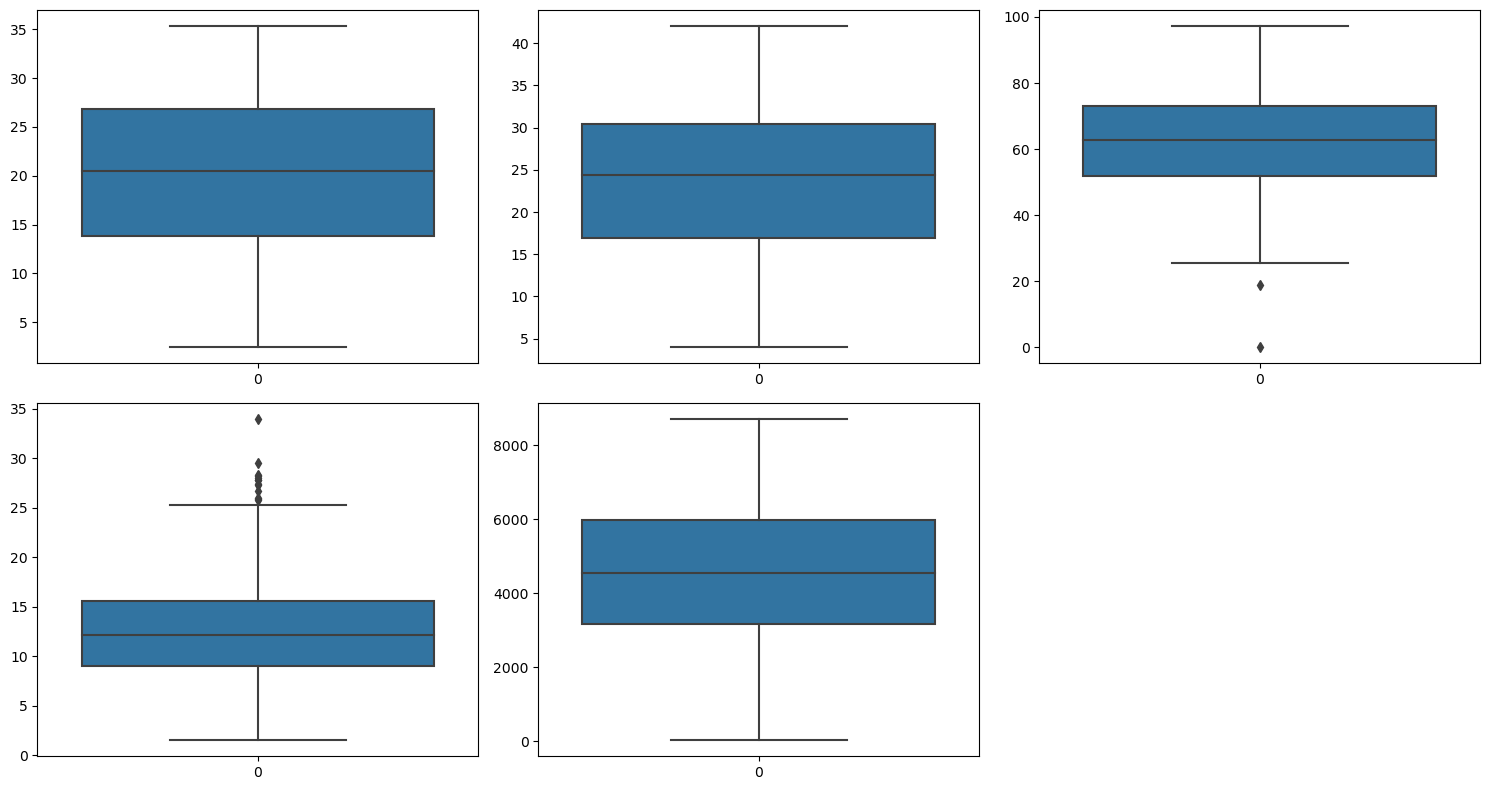

In [26]:
# Create a new dataframe of only numeric variables:
numerical_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # Pre-allocate figure and axes

for i in range(5):  # Iterate for 5 plots
    var = numerical_vars[i]
    sns.boxplot(data=bikes[var], ax=axes.flat[i])  # Efficient plotting

# Clear the last subplot
axes.flat[-1].set_visible(False)  # Hide the extra plot

plt.tight_layout()
plt.show()

In [27]:
bikes[numerical_vars].describe()

,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000
mean,20.319259,23.726322,62.765175,12.763620,4508.006849
std,7.506729,8.150308,14.237589,5.195841,1936.011647
min,2.424346,3.953480,0.000000,1.500244,22.000000
25%,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,26.880615,30.445775,72.989575,15.625589,5966.000000
max,35.328347,42.044800,97.250000,34.000021,8714.000000


Hence, there are no such outliers to be treated

### Univariate analysis for 
1. Cateforical variables
2. Continuous variables

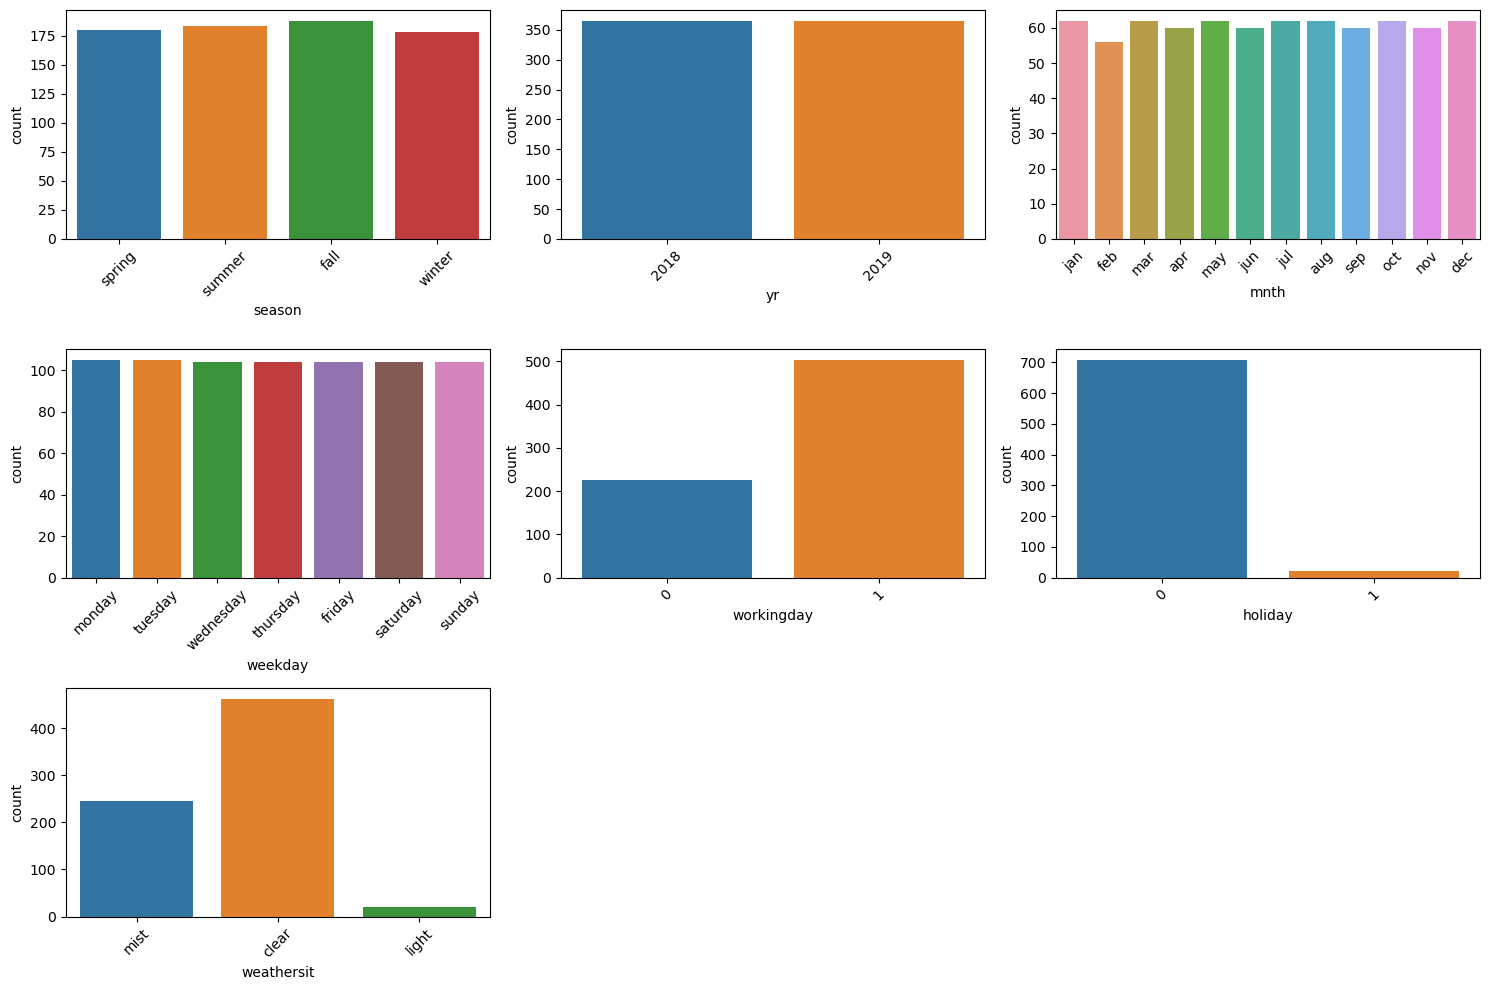

In [28]:
# 1.
categorical_vars = ['season', 'yr', 'mnth', 'weekday', 'workingday', 'holiday', 'weathersit']

fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Pre-allocate figure and axes

for i in range(7):  # Iterate only for the first 7 plots
    var = categorical_vars[i]
    sns.countplot(x=var, data=bikes, ax=axes.flat[i])  # Efficient plotting
    axes.flat[i].set_xticklabels(axes.flat[i].get_xticklabels(), rotation=45)  # Rotate labels

# Clear the last two subplots
axes.flat[-2].set_visible(False)
axes.flat[-1].set_visible(False)

plt.tight_layout()
plt.show()


### Observation-
* **Predictable Data:** Limited insights as factors like seasons, years, months have pre-defined, uniform values.
* **Working Days:** Significantly dominate non-working days.
* **Holidays:** Rare occurrence.
* **Weather:** Clear dominates, followed by mist (half as frequent), light rain (rare), no heavy rain.

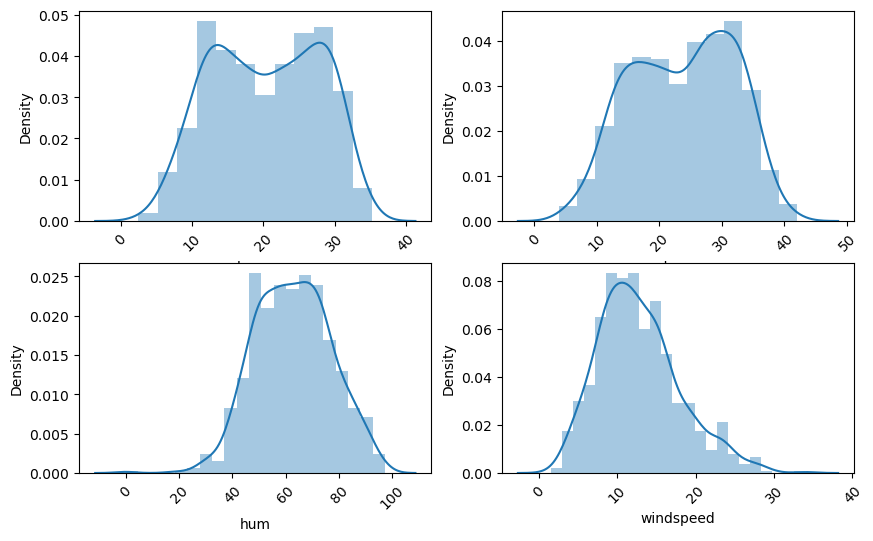

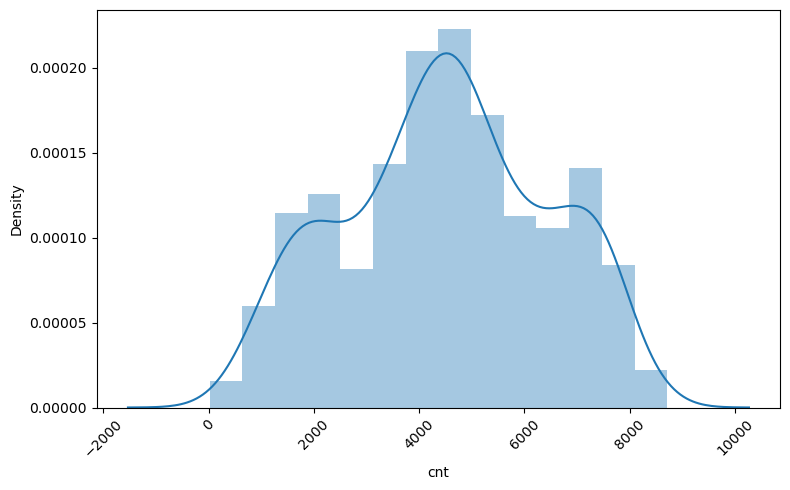

In [29]:
# 2. 
continuous_vars = ['temp', 'atemp', 'hum', 'windspeed','cnt']  # Variables for the grid

fig, axes = plt.subplots(2, 2, figsize=(10, 6))  # 2x2 grid for 4 variables

for i in range(4):  # Iterate for plots in the grid
    col = continuous_vars[i]
    sns.distplot(bikes[col], hist=True, ax=axes.flat[i])

    ax = axes.flat[i]  # Get the current axis
    ax.xaxis.set_tick_params(rotation=45)  # Rotate x-axis labels

    axes.flat[i].set_ylabel("Density")

# Separate plot for 'cnt'
plt.figure(figsize=(8, 5))  # Create a new figure
sns.distplot(bikes['cnt'], hist=True)  # Plot the distribution of 'cnt'
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.ylabel("Density")

plt.tight_layout()  # Adjust spacing for both figures
plt.show()


### Observations -

**Distribution Patterns:**

* **Temperature:** Explore differences between "temp" and "atemp", their interactions with other variables, and potential thresholds affecting ridership.
* **Humidity:** Examine potential impact on usage, relationships with temperature, and non-normality for further analysis.
* **Windspeed:** Investigate non-linear effects on bike counts and combined influence with other variables.
* **Bike Count:** Characterize its distribution (skewness, outliers) and consider transformations for analysis.

**Insights for Bike Sharing System:**

* **Weather-Based Strategies:** Promote usage during optimal conditions, adjust availability during unfavorable ones.
* **Infrastructure Considerations:** Explore wind-shielded paths, covered parking, and humidity control measures.

### Bivariate Analysis for
1. Continuous-continuous variables
2. Categorical-Numerical Variables

A. Using Heatmap
B. Using Pairplots

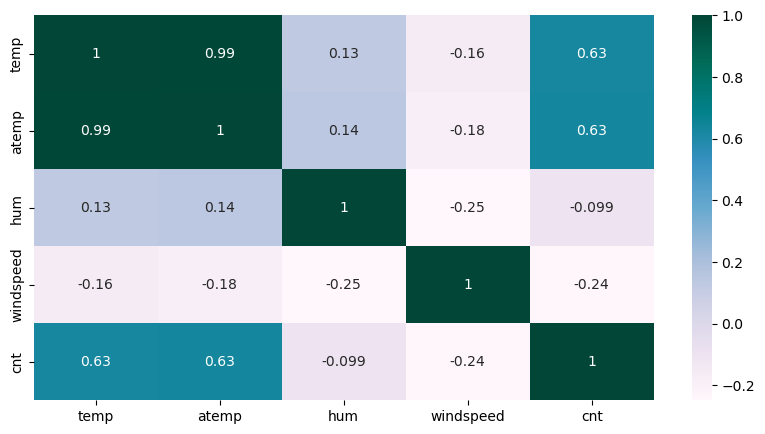

In [30]:
# A.
continuous_vars = ['temp','atemp','hum','windspeed','cnt']
plt.figure(figsize = [10, 5])
sns.heatmap(bikes[continuous_vars].corr(),annot=True, cmap='PuBuGn')

plt.show()

### Observations-

**1. Redundant Temps:** Strong temperature correlation suggests keeping only one (temp or atemp) to avoid multicollinearity and optimize model performance.

**2. Expected Correlations:** Bike usage correlates positively with temperature and negatively with windspeed and humidity, as expected.

This shortened version retains the core points of the original while being even more concise.


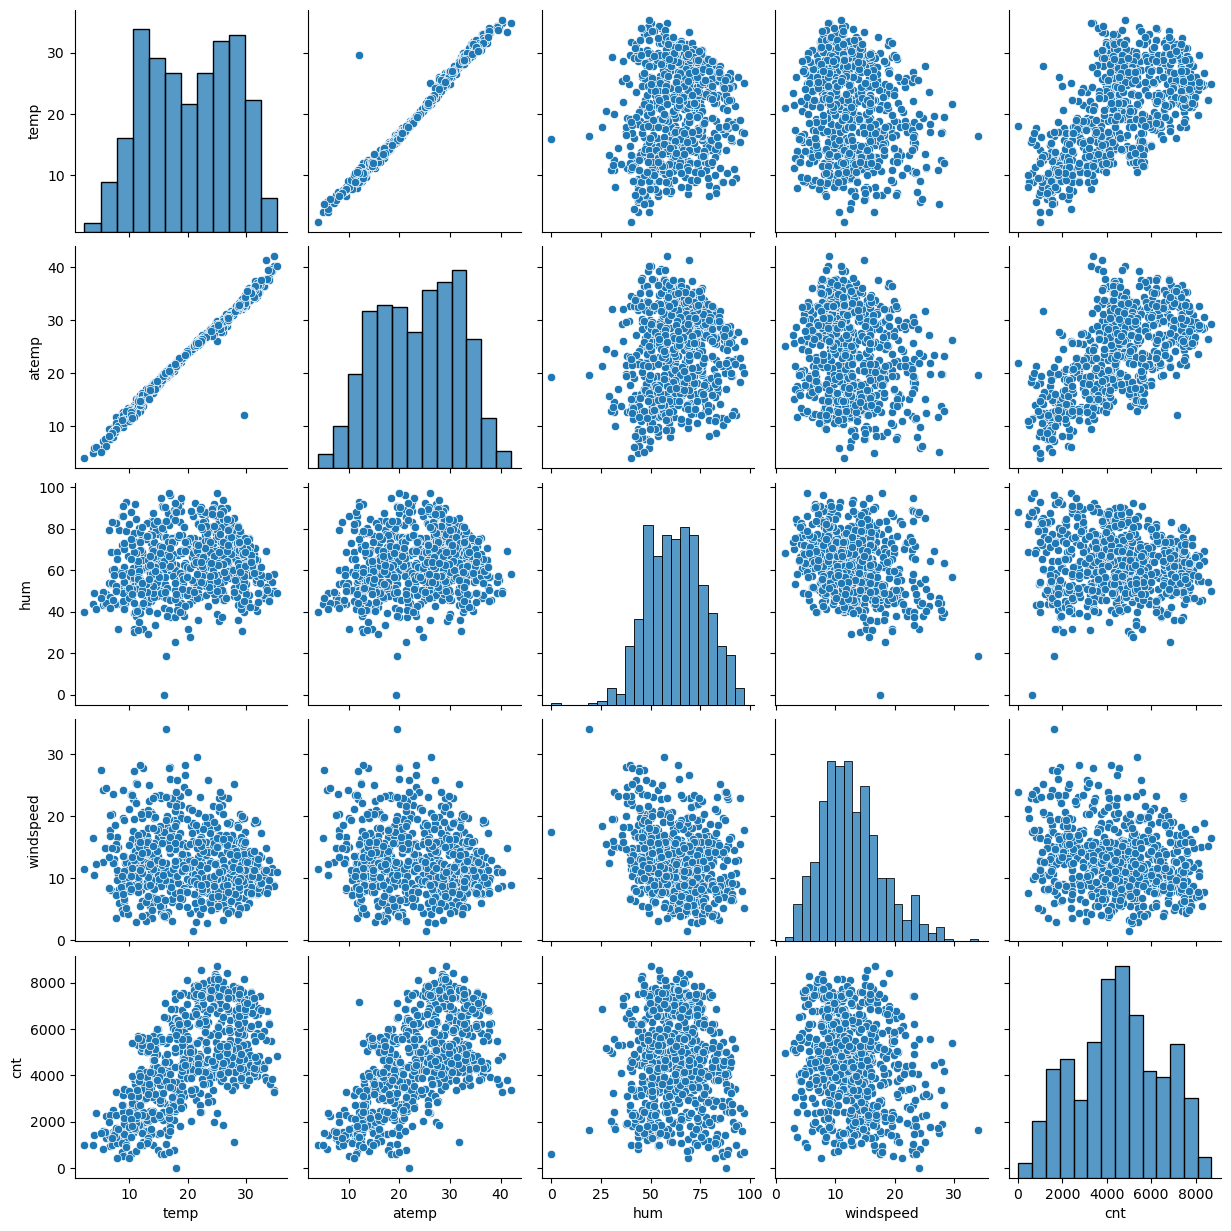

In [31]:
# B.
# Select variables for visualization
continuous_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

# Create the pairplot directly from the dataset
sns.pairplot(bikes, vars=continuous_vars)  # Combine data and variables for clarity
plt.show()


### Observations-

- **Concordant Insights:** The pairplot corroborates the heatmap's revelations regarding variable relationships.
- **Absence of Salient Outliers:** No conspicuous outliers emerge, auspiciously suggesting a potentially uncomplicated model training process.
- **Persisting Temperature Interdependence:** The tenacious correlation between `temp` and `atemp` signals potential multicollinearity. While judicious removal might be advantageous, both shall be provisionally retained, ceding agency to the model to elucidate their relative predictive utility.

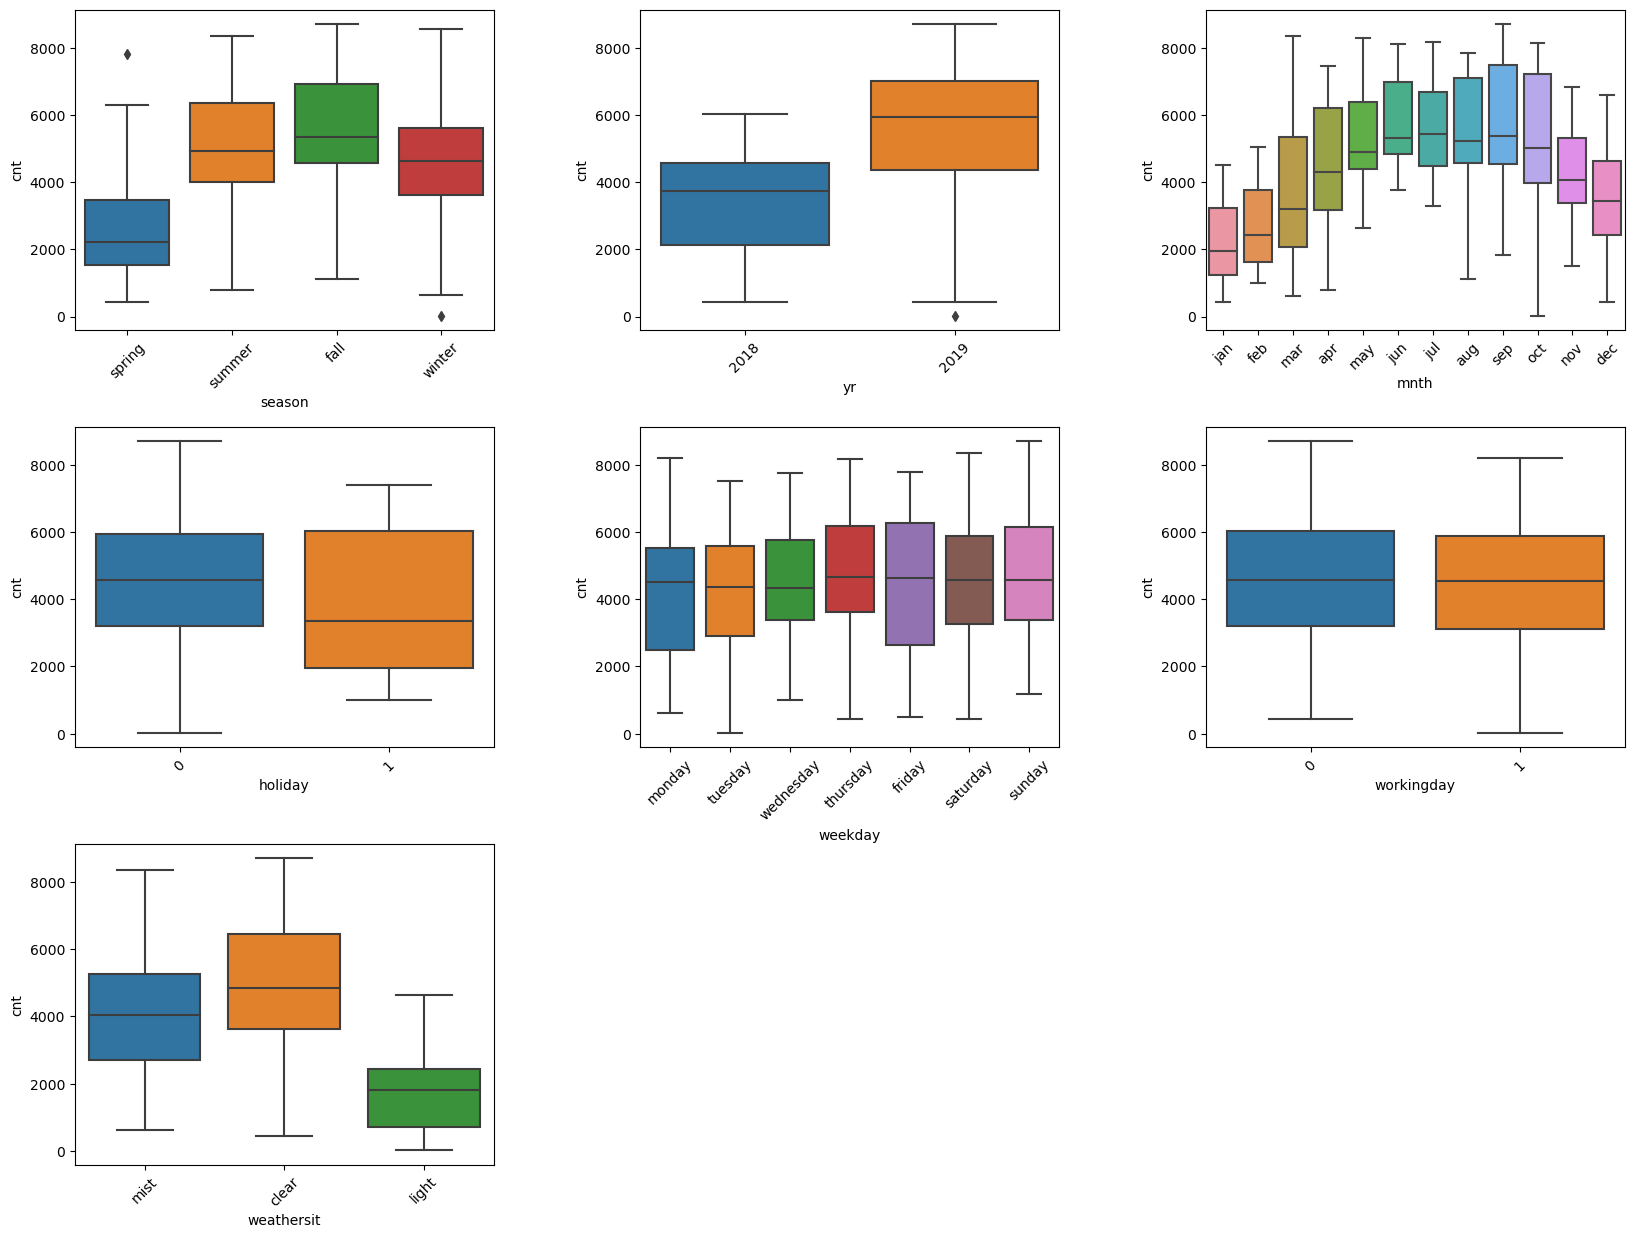

In [32]:
plt.figure(figsize=[20,15])

Continuous_vars = ['season','yr','mnth','holiday','weekday','workingday','weathersit']

# sns.boxplot(x='season', y = 'cnt', data=bikes)
plt.subplots_adjust(hspace=0.30,wspace=0.35)
for i,col in enumerate(Continuous_vars):
    plt.subplot(3,3,i+1)
    sns.boxplot(x = col, y = 'cnt', data = bikes)
    plt.xticks(rotation=45)
    
plt.show()

### Observations-

1. **Seasonality:** Summer and Fall reign supreme, Spring lags behind, Winter in between. Peak usage: Sept-Oct.
2. **Year-on-Year Growth:** Significant increase in bike usage from year 1 to year 2.
3. **Holidays vs. Non-Holidays:** Higher median usage on non-holidays, but wider range on holidays.
4. **Day of the Week:** Similar median usage across weekdays, with varying spreads.
5. **Weather:** Light rain dips usage, clear skies peak, mist causes moderate decline.

### **Creating dummies varibles:**

**Transform multi-level categorical variables into numerical representations for analysis, while leaving binary variables unchanged.**

**Specifically:**

- **Convert variables with multiple categories:**
    - "season," "mnth," "weekday," "weathersit," and "yr"
    - Create dummy variables (n-1 columns for each) to capture numerical relationships.
- **Leave binary variables as-is:**
    - "holiday" and "workingday" (0 or 1 values)
    - No transformation needed for analysis.


In [33]:
# List of categorical variables to transform into dummy variables
dum_cat_vars = ['season', 'mnth', 'weekday', 'weathersit', 'yr']

# Loop through each categorical variable
for var in dum_cat_vars:
   # Create dummy variables for the current variable
   temp_var = pd.get_dummies(bikes[var], drop_first=True)  # Drop first dummy to avoid redundancy

   # Attach the new dummy columns to the original dataset
   bikes = pd.concat([bikes, temp_var], axis=1)  # Combine along columns

   # Remove the original categorical column, as it's now represented by dummies
   bikes.drop(var, axis=1, inplace=True)

# Preview the first few rows of the updated dataset to check results
bikes.head()


,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep,monday,saturday,sunday,thursday,tuesday,wednesday,light,mist,2019
0,0,1,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,0,1,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
bikes.shape

(730, 30)

#### Splitting the Data in Train and Test Sets

In [35]:
# Set a seed for consistent shuffling of the data (like mixing a deck of cards)
np.random.seed(0)

# Split the bike data into training and test sets
# - 70% for training (like a practice set to learn from)
# - 30% for testing (like a surprise quiz to evaluate learning)
# - random_state ensures consistent splits across multiple runs
bikes_train, bikes_test = train_test_split(bikes, train_size=0.7, random_state=100)

# Check the shape of each dataset to confirm the split (like counting cards in each pile)
print("Training set shape:", bikes_train.shape)
print("Test set shape:", bikes_test.shape)


Training set shape: (510, 30)
Test set shape: (220, 30)


In [36]:
# Preprocess numerical features by applying MinMaxScaler for improved model
# convergence and fairer feature importance comparison. Exclude 'binary' columns
# and dummy variables as they already represent categorical levels.

scaler = MinMaxScaler()
num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
bikes_train[num_vars] = scaler.fit_transform(bikes_train[num_vars])

# This approach ensures numerical features contribute equally to model learning
# and simplifies interpretation of model coefficients later.

In [37]:
bikes_train.head()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep,monday,saturday,sunday,thursday,tuesday,wednesday,light,mist,2019
576,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
426,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1
728,0,1,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
482,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
111,0,0,0.345824,0.318819,0.751824,0.380981,0.191095,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [38]:
# Separate target variable "cnt" (bike count) from the remaining features in the training set.

y_train = bikes_train.pop('cnt')
X_train = bikes_train

# This allows the model to clearly distinguish between features and the desired outcome
# during training, facilitating efficient learning and improving prediction accuracy.


#### Building Model

To optimize model performance with a large feature set (30), we employ a two-step process:

1. Recursive Feature Elimination (RFE) reduces the initial feature space to 15 important candidates.
2. Subsequent backward selection refines this subset, identifying the final set of statistically significant features for model building.

In [39]:
# Utilize Linear Regression model for initial feature importance analysis.

lm = LinearRegression()
lm.fit(X_train, y_train)

# This initial fit establishes a baseline for feature impact assessment. Subsequent
# feature selection techniques (RFE and backward selection) will build upon this
# foundation to identify the most influential features and optimize model performance.

LinearRegression()

In [40]:
# Employ RFE with Linear Regression model to conduct initial feature selection.

rfe = RFE(lm, n_features_to_select=15)
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=15)

In [41]:
# Display feature importance information for evaluation and understanding.
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('holiday', True, 1),
 ('workingday', False, 4),
 ('temp', True, 1),
 ('atemp', False, 3),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('aug', False, 10),
 ('dec', True, 1),
 ('feb', False, 2),
 ('jan', True, 1),
 ('jul', True, 1),
 ('jun', False, 12),
 ('mar', False, 15),
 ('may', False, 9),
 ('nov', True, 1),
 ('oct', False, 13),
 ('sep', True, 1),
 ('monday', False, 8),
 ('saturday', False, 5),
 ('sunday', False, 6),
 ('thursday', False, 14),
 ('tuesday', False, 7),
 ('wednesday', False, 11),
 ('light', True, 1),
 ('mist', True, 1),
 ('2019', True, 1)]

In [42]:
# Extract the 15 features shortlisted by RFE for subsequent model refinement.
col = X_train.columns[rfe.support_]
col
# This step leverages RFE's ranking of features based on their contribution to the model
# to identify a promising subset for further analysis. This reduces complexity,
# mitigates overfitting risk, and enhances understanding of key factors influencing
# the target variable.

Index(['holiday', 'temp', 'hum', 'windspeed', 'spring', 'summer', 'winter',
       'dec', 'jan', 'jul', 'nov', 'sep', 'light', 'mist', '2019'],
      dtype='object')

### Constructing a statistical model with statsmodel library for in-depth performance analysis

In [43]:
# Utilize shortlisted features identified by RFE for model building.
X_train_rfe = X_train[col]

# Integrate a constant term for model stability and interpretability.
X_train_lm = sm.add_constant(X_train_rfe)

# Construct an Ordinary Least Squares (OLS) regression model using statsmodel.
lm_1 = sm.OLS(y_train, X_train_lm).fit()

# Obtain detailed statistical report for model evaluation and analysis.
print(lm_1.summary())

# This approach leverages statsmodel's robust capabilities to perform in-depth
# statistical analysis of the model, including hypothesis testing, confidence
# interval assessment, and R-squared estimation, facilitating comprehensive
# model evaluation and interpretation.


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     179.4
Date:                Thu, 04 Jan 2024   Prob (F-statistic):          8.15e-189
Time:                        22:54:56   Log-Likelihood:                 514.19
No. Observations:                 510   AIC:                            -996.4
Df Residuals:                     494   BIC:                            -928.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3197      0.036      8.859      0.0

In [44]:
# Assess potential multicollinearity among shortlisted features using Variance
# Inflation Factors (VIFs). High VIFs (>5-10) indicate redundant information,
# impacting model stability and interpretability. This analysis guides further
# feature selection and contributes to robust, interpretable model building.

vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

# This approach leverages VIF analysis to detect potentially correlated features
# within the shortlisted subset, enabling informed feature selection decisions
# and promoting the development of a stable, interpretable, and ultimately
# more accurate model.


,Features,VIF
2,hum,30.89
1,temp,17.79
3,windspeed,4.72
4,spring,4.37
6,winter,4.06
5,summer,2.82
13,mist,2.32
14,2019,2.09
10,nov,1.85
8,jan,1.75


In [45]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Function for VIF calculation
def calculate_vif(X):
    vif = pd.DataFrame({'Features': X.columns})
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    return vif.sort_values(by='VIF', ascending=False)

# Iterate through feature removal and model building
features_to_remove = ['jan', 'holiday', 'spring', 'jul']
for feature in features_to_remove:
    X_train_new = X_train_rfe.drop(feature, axis=1)  # Drop feature
    X_train_lm = sm.add_constant(X_train_new)       # Add constant term

    # Create model with descriptive name
    model = f"lm_{features_to_remove.index(feature) + 2}"  # Dynamic model naming
    globals()[model] = sm.OLS(y_train, X_train_lm).fit()  # Assign model to global scope

    # Print model summary and VIFs
    print(f"Model without {feature}:\n{globals()[model].summary()}")
    vif = calculate_vif(X_train_new)
    print(f"VIFs for model without {feature}:\n{vif}")

# Address high VIF despite low p-value
X_train_new = X_train_new.drop(['hum'], axis=1)
X_train_lm = sm.add_constant(X_train_new)

# Create final model
lm_6 = sm.OLS(y_train, X_train_lm).fit()
print("Final Model:\n", lm_6.summary())

# Calculate VIFs for final model
vif = calculate_vif(X_train_new)
print("VIFs for Final Model:\n", vif)


Model without jan:
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     190.0
Date:                Thu, 04 Jan 2024   Prob (F-statistic):          9.86e-189
Time:                        22:54:56   Log-Likelihood:                 511.25
No. Observations:                 510   AIC:                            -992.5
Df Residuals:                     495   BIC:                            -929.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3002      0.035 

VIFs for model without spring:
     Features    VIF
2         hum  20.42
1        temp  13.44
3   windspeed   3.64
5      winter   2.77
12       mist   2.17
13       2019   2.05
4      summer   1.89
9         nov   1.84
7         jan   1.62
6         dec   1.56
8         jul   1.55
10        sep   1.32
11      light   1.22
0     holiday   1.06
Model without jul:
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     188.5
Date:                Thu, 04 Jan 2024   Prob (F-statistic):          5.38e-188
Time:                        22:54:56   Log-Likelihood:                 509.49
No. Observations:                 510   AIC:                            -989.0
Df Residuals:                     495   BIC:                            -925.5
Df 

### Delving into the Train Data: A Residual Analysis Journey

Text(0.5, 0, 'Residuals')

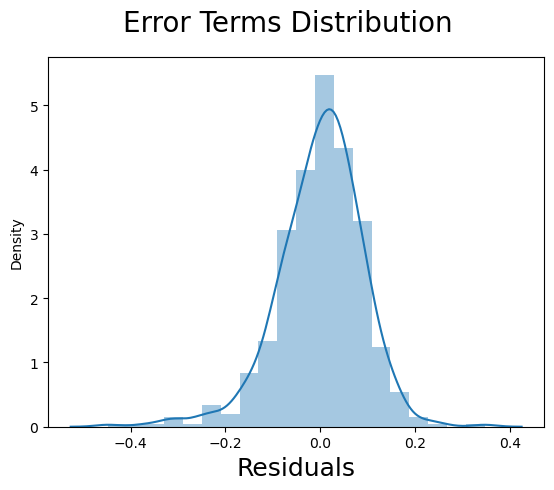

In [46]:
# Predict train data to calculate residuals for normality assessment.
y_train_cnt = lm_6.predict(X_train_lm)

# Plot histogram of residuals to visualize their distribution.
# 20 bins provide sufficient detail for normality evaluation.
sns.distplot(y_train - y_train_cnt, bins=20)

# Title and labels clarify the plot's purpose and meaning.
plt.suptitle('Error Terms Distribution', fontsize=20)
plt.xlabel('Residuals', fontsize=18)

# This analysis verifies one key assumption of linear regression,
# ensuring model validity and reliable predictions.


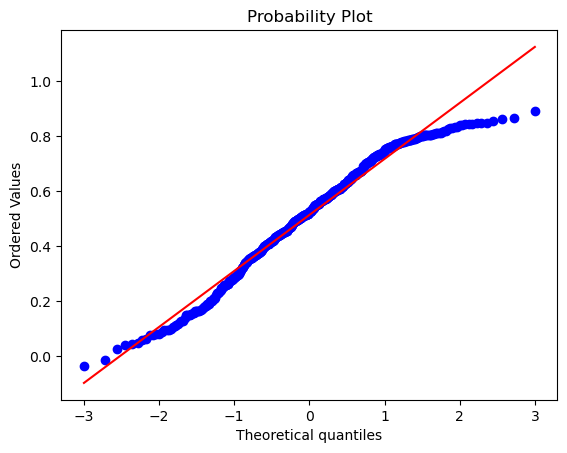

In [47]:
# Import the stats module from SciPy for statistical functions
from scipy import stats

# Create a QQ plot to visually assess normality of y_train_cnt
stats.probplot(
    y_train_cnt,  # Data to be plotted
    dist='norm',  # Specify a normal distribution for comparison
    plot=plt      # Designate Matplotlib as the plotting backend
)

# Display the generated QQ plot for analysis
plt.show()

### Observations-

**QQ Plots provide a visual check for normality in residuals. Close alignment of plotted points with a diagonal line signals a normal distribution, as observed in this case.**

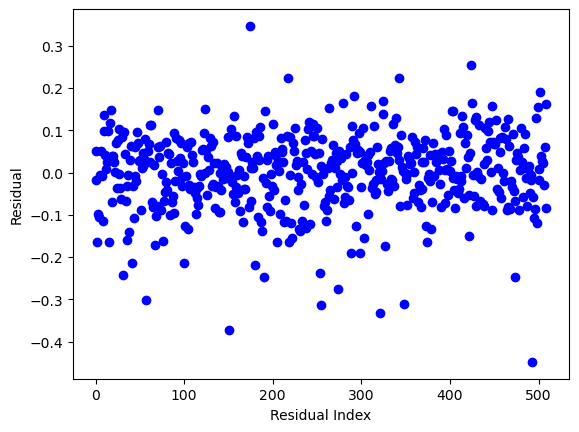

In [48]:
# Calculate the residuals (differences between y_train and y_train_cnt)
residual = y_train - y_train_cnt

# Create a DataFrame to store the residuals
res_df = pd.DataFrame({
   'index': residual.index,  # Store the original index values for reference
   'res': residual.values   # Store the calculated residual values
})

# Plot the residuals as a scatter plot
plt.plot(res_df.index, res_df.res, 'bo', label='Residuals')  # Plot blue circles for residuals

# Add labels to the x and y axes for clarity
plt.xlabel('Residual Index')
plt.ylabel('Residual')

# Display the plot
plt.show()


### Observations-
**The scatter plot reveals a total lack of pattern in the residuals. They appear completely random, indicating independence from each other. This randomness confirms the assumption of independent errors**

### Transform the test data using the same scaling parameters learned from the training data.


In [49]:
# Identify the numerical variables to be scaled:
num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

# Apply the scaling transformation to the specified columns:
bikes_test[num_vars] = scaler.transform(bikes_test[num_vars])


In [50]:
# --- Dividing into features and target ---

# Extract the target variable ('cnt') directly into y_test
y_test = bikes_test.loc[:, 'cnt']

# Remove the target variable from bikes_test to create X_test
X_test = bikes_test.drop('cnt', axis=1)

# --- Preparing for predictions ---

# Select only columns present in X_train_new for consistency
X_test_new = X_test.filter(items=X_train_new.columns)

# Add a constant term for the intercept
X_test_new = sm.add_constant(X_test_new)

# --- Generating predictions ---

# Use the model to predict on the prepared test set
y_pred = lm_6.predict(X_test_new)


### Model Evaluation

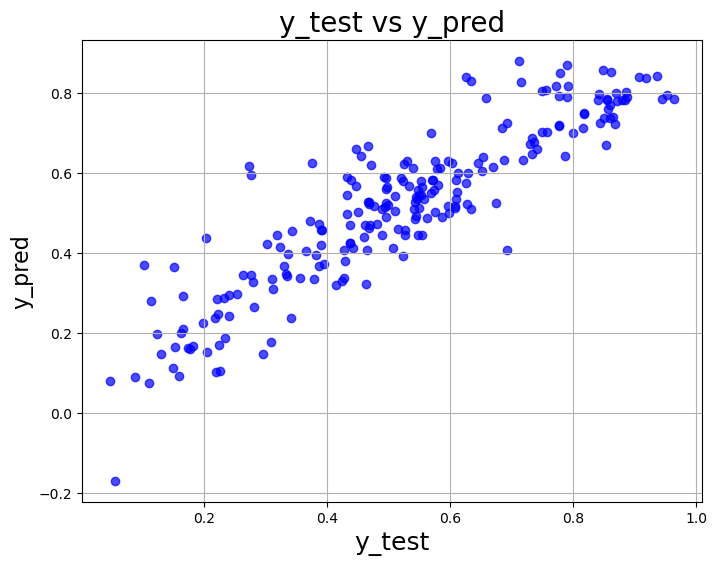

In [51]:
import matplotlib.pyplot as plt

# Create a figure and axes object for more control
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size as needed

# Plot the scatter points with custom formatting
ax.scatter(y_test, y_pred, alpha=0.7, color='blue')  # Adjust alpha for transparency

# Set plot title, labels, and font sizes
ax.set_title('y_test vs y_pred', fontsize=20)
ax.set_xlabel('y_test', fontsize=18)
ax.set_ylabel('y_pred', fontsize=16)

# Add a grid for better readability
ax.grid(True)

# Show the plot
plt.show()


In [52]:
r2_score(y_test, y_pred)

0.811933825139261

### Observations-
**The model performs surprisingly well on the test data, achieving an R² score close to 80% compared to 83.5% on the training data. This suggests excellent generalizability and suitability for real-world use**

The model coefficients are as shown below:


In [53]:
print(lm_6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     195.6
Date:                Thu, 04 Jan 2024   Prob (F-statistic):          1.23e-185
Time:                        22:54:58   Log-Likelihood:                 501.12
No. Observations:                 510   AIC:                            -974.2
Df Residuals:                     496   BIC:                            -915.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2379      0.032      7.373      0.0

##  Model interpretation:

**Key influencers on bike count:**

* **Temperature:** Temperature has the biggest impact. Each degree increase leads to a roughly 0.55 rise in bike count.
* **Weather:** Light rain, mist, and windspeed all negatively affect the count. Increased windspeed by 1 unit decreases count by 0.15, for example.
* **Time:** Weekend days, especially Saturdays, see higher counts, while working days lead to a slight increase.
* **Season:** Year 2019 (second year of data) and summer/winter see an overall boost in bike count. September specifically has the highest monthly influence.

**Putting it together:**

The baseline bike count is about -0.08 without any specific factors influencing it. Each factor then adds or subtracts from this baseline based on its influence. For example, a warmer summer day on a Saturday with low wind and no rain will likely see a significantly higher bike count compared to a cold, windy weekday with mist.

**Equation is:**

cnt = (00561 * workingday) + 0.0750 + (0.5499 * temp) + (0.0886 * summer) + (-0.1552 * windspeed) + (0.1307 * winter) + (0.0974 * sep) + (0.0675 * saturday) + (0.2331 * yr) + (-0.0800 * mist) + (-0.2871 * light)

**Equation breakdown:**

* `cnt`: Predicted bike count
* `0.0750`: Baseline count
* Each subsequent term represents the influence of a specific factor:
    * `workingday`: +0.0561 units for each working day
    * `temp`: +0.5499 units per degree increase
    * `windspeed`: -0.1552 units per unit increase
    * `summer`, `winter`, `sep`, `saturday`: Positive influence on count
    * `light`, `mist`: Negative influence on count
    * `yr`: +0.2331 units for year 2019

## Top 3 Contributors:

**Temperature:**

* **Temperature rules the road:** A one-degree temperature rise boosts bike demand by a whopping 0.55 units, making it the clear king of influence.
* **Demand heats up with temperature:** Forget your coffee, grab your bike! Warmer weather is the biggest driver of demand, with each degree leading to a significant 0.55-unit increase.

**Light Rain:**

* **Light rain chills the demand:** Think twice before grabbing your bike next time a light drizzle starts. Even a small increase in light rain translates to a 0.29-unit drop in demand.
* **Rain puts the brakes on demand:** While a sprinkle might sound pleasant, it sends bike demand into a skid, leading to a 0.29-unit decrease for every unit increase in light rain.

**Year 2019:**

* **2019: The year the bike boom began:** Forget just a seasonal boom, 2019 saw a fundamental shift in demand. Compared to 2018, there was a natural increase of 0.2331 units, and this trend is likely to continue unless something changes the landscape.
* **Year-on-year growth pedals forward:** 2019 wasn't just a good year, it was a turning point. Bike demand saw a steady year-on-year growth of 0.2331 units, suggesting a promising future for cycling.

**Bonus:**

* **The Big Three of Bike Demand:** Temperature, light rain, and 2019 – these are the three forces shaping the cycling world. Understanding their impact is key to predicting future trends and keeping the wheels rolling.


